In [1]:
from google.colab import files
import pandas as pd
import os
import shutil
import numpy as np
from PIL import Image
from collections import Counter
from tqdm.notebook import tqdm as tq
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import cv2
import albumentations as A
import numpy as np

In [ ]:
from google.colab import files
files.upload()

In [3]:
# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download ashishmotwani/tomato

In [5]:
!unzip tomato.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/Late_blight/9aaf4a7d-12ac-457a-a18c-1f7ea13065de___RS_Late.B 5179.JPG  
  inflating: valid/Late_blight/9afc2537-1b13-4c25-b5ed-5b8de511b0ab___GHLB2 Leaf 9033.JPG  
  inflating: valid/Late_blight/9bb49d22-976d-40c3-bc9a-bff5cbbd8e28___RS_Late.B 5057.JPG  
  inflating: valid/Late_blight/9c274db5-2f89-4f3c-b9e2-4d5ebc54ddad___GHLB2 Leaf 9096.JPG  
  inflating: valid/Late_blight/9c726f4e-045b-4080-b53d-d7e66d45bcb1___RS_Late.B 4876.JPG  
  inflating: valid/Late_blight/9e5dd34f-124c-4a64-ba9f-77c8d05faa9c___GHLB2 Leaf 8749.JPG  
  inflating: valid/Late_blight/9e633823-3dde-450c-8172-733021e4dff0___RS_Late.B 6414.JPG  
  inflating: valid/Late_blight/9ecb8001-2f48-4487-b287-535dbcfb5c2f___RS_Late.B 6206.JPG  
  inflating: valid/Late_blight/9f7dcd60-e691-4c1e-830e-7495f7cc123d___RS_Late.B 6166.JPG  
  inflating: valid/Late_blight/Bacterial_spots2276_jpg.rf.5becd3793ec2a532bf8f111d60911c63.jpg  
  inflating: valid/Late_blight

In [6]:
!mkdir original_data
!mkdir combine_data
!mkdir augmented_data

In [7]:
# Path ke folder dataset asli
train_dir = 'train'
val_dir = 'valid'

# Folder hasil penggabungan
original_data_dir = 'original_data'
os.makedirs(original_data_dir, exist_ok=True)

# Fungsi untuk menggabungkan data dari folder sumber ke folder tujuan
def merge_data(source_dir, destination_dir):
    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        if os.path.isdir(class_dir):
            destination_class_dir = os.path.join(destination_dir, class_name)
            os.makedirs(destination_class_dir, exist_ok=True)
            for filename in os.listdir(class_dir):
                src_file = os.path.join(class_dir, filename)

                # Hindari overwrite jika nama file sama
                dst_file = os.path.join(destination_class_dir, filename)
                if os.path.exists(dst_file):
                    name, ext = os.path.splitext(filename)
                    i = 1
                    while os.path.exists(os.path.join(destination_class_dir, f"{name}_{i}{ext}")):
                        i += 1
                    dst_file = os.path.join(destination_class_dir, f"{name}_{i}{ext}")

                shutil.copy(src_file, dst_file)

# Gabungkan data train dan test ke dalam original_data
merge_data(train_dir, original_data_dir)
merge_data(val_dir,original_data_dir)

print("Data telah digabungkan ke dalam folder 'original_data'.")


Data telah digabungkan ke dalam folder 'original_data'.


In [8]:
# Path ke direktori utama
base_dir = 'original_data'

# Mapping nama folder lama ke nama baru
rename_map = {
    'Spider_mites Two-spotted_spider_mite': 'Tungau_dua_bercak',
    'Tomato_Yellow_Leaf_Curl_Virus': 'Virus_keriting_daun_kuning',
    'powdery_mildew': 'Embun_tepung',
    'Tomato_mosaic_virus': 'Virus_mosaik_tomat',
    'Leaf_Mold': 'Jamur_daun',
    'Septoria_leaf_spot': 'Bercak_daun_Septoria',
    'Early_blight': 'Busuk_daun_awal',
    'Bacterial_spot': 'Bercak_bakteri',
    'healthy': 'Sehat',
    'Late_blight': 'Busuk_daun_lanjut',
    'Target_Spot': 'Bercak_target'
}

# Ganti nama folder
for old_name, new_name in rename_map.items():
    old_path = os.path.join(base_dir, old_name)
    new_path = os.path.join(base_dir, new_name)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Berhasil mengganti '{old_name}' menjadi '{new_name}'")
    else:
        print(f"Folder '{old_name}' tidak ditemukan")

print("Nama Penyakit dalam folder sudah diganti.")


Berhasil mengganti 'Spider_mites Two-spotted_spider_mite' menjadi 'Tungau_dua_bercak'
Berhasil mengganti 'Tomato_Yellow_Leaf_Curl_Virus' menjadi 'Virus_keriting_daun_kuning'
Berhasil mengganti 'powdery_mildew' menjadi 'Embun_tepung'
Berhasil mengganti 'Tomato_mosaic_virus' menjadi 'Virus_mosaik_tomat'
Berhasil mengganti 'Leaf_Mold' menjadi 'Jamur_daun'
Berhasil mengganti 'Septoria_leaf_spot' menjadi 'Bercak_daun_Septoria'
Berhasil mengganti 'Early_blight' menjadi 'Busuk_daun_awal'
Berhasil mengganti 'Bacterial_spot' menjadi 'Bercak_bakteri'
Berhasil mengganti 'healthy' menjadi 'Sehat'
Berhasil mengganti 'Late_blight' menjadi 'Busuk_daun_lanjut'
Berhasil mengganti 'Target_Spot' menjadi 'Bercak_target'
Nama Penyakit dalam folder sudah diganti.


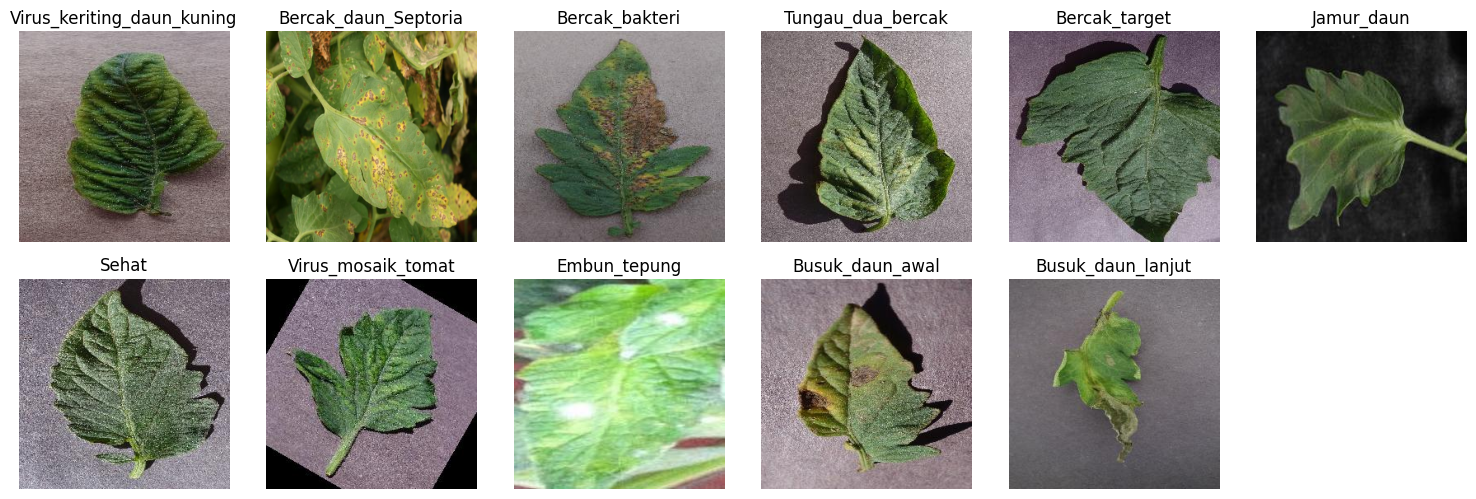

In [9]:
def visualize_images(base_dir):
    """Menampilkan satu gambar per label dari direktori tertentu."""

    plt.figure(figsize=(15, 15))

    for i, label in enumerate(os.listdir(base_dir)):
        label_dir = os.path.join(base_dir, label)
        if os.path.isdir(label_dir):
            image_files = [f for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))]
            if image_files:
                random_image = random.choice(image_files)
                image_path = os.path.join(label_dir, random_image)
                image = plt.imread(image_path)

                plt.subplot(6, 6, i + 1)
                plt.imshow(image)
                plt.title(label)
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Contoh visualisasi gambar dari folder training
visualize_images('original_data')

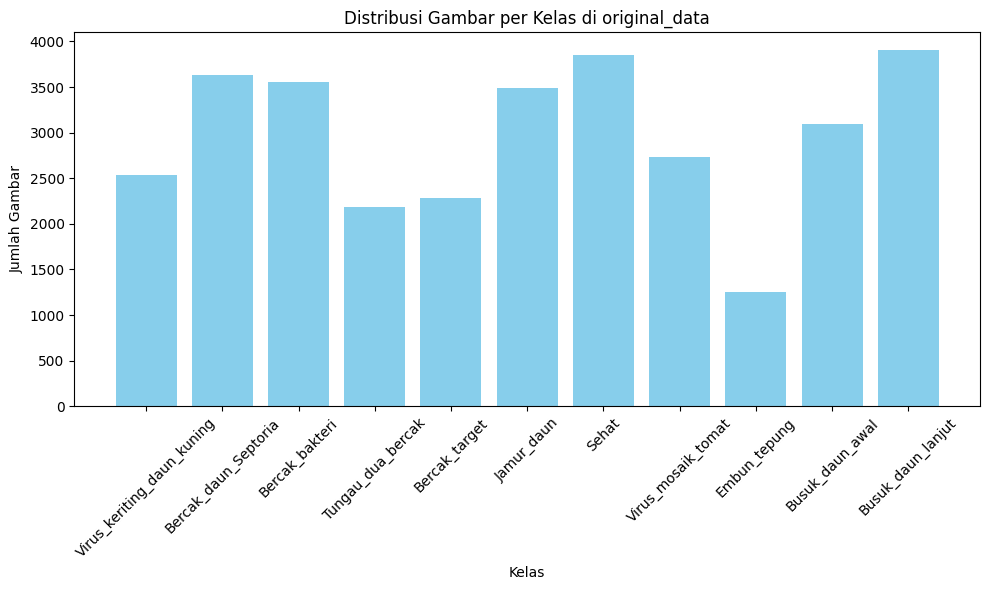

In [10]:
def plot_class_distribution(dataset_dir):
    """Menampilkan grafik distribusi jumlah gambar per kelas."""
    class_counts = {}

    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            num_images = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
            class_counts[class_name] = num_images

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title('Distribusi Gambar per Kelas di original_data')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Tampilkan grafik
plot_class_distribution('original_data')

In [11]:
# Path ke dataset asli (tiap kelas di dalam subfolder)
input_base_dir = 'original_data'
output_base_dir = 'augmented_data'

# Mapping kelas dan jumlah gambar tambahan yang diinginkan
augment_target = {
    'Embun_tepung': 2650,
    'Virus_mosaik_tomat': 1150,
    'Busuk_daun_lanjut': 0,
    'Sehat': 0,
    'Jamur_daun': 400,
    'Virus_keriting_daun_kuning': 1300,
    'Bercak_bakteri': 300,
    'Tungau_dua_bercak': 1700,
    'Bercak_target': 1600,
    'Busuk_daun_awal': 800,
    'Bercak_daun_Septoria': 250
}

# Transformasi kombinasi augmentasi
transform = A.Compose([
    A.Rotate(limit=20, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.5),
    A.ZoomBlur(p=0.2),  # FIXED: tidak lagi pakai zoom_limit
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5)
])

# Buat output folder jika belum ada
os.makedirs(output_base_dir, exist_ok=True)

# Proses setiap kelas
for class_name, target_aug_count in augment_target.items():
    input_class_dir = os.path.join(input_base_dir, class_name)
    output_class_dir = os.path.join(output_base_dir, class_name)
    os.makedirs(output_class_dir, exist_ok=True)

    image_files = [f for f in os.listdir(input_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    num_original = len(image_files)

    if num_original == 0:
        print(f"Skipping {class_name} because no original images were found.")
        continue

    # Hitung berapa augmentasi per gambar asli yang perlu dibuat
    aug_per_image = target_aug_count // num_original + 1

    pbar = tq(total=target_aug_count, desc=f'Augmenting {class_name}')
    total_augmented = 0

    for img_file in image_files:
        if total_augmented >= target_aug_count:
            break

        img_path = os.path.join(input_class_dir, img_file)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Failed to read {img_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for i in range(aug_per_image):
            if total_augmented >= target_aug_count:
                break
            augmented = transform(image=image)
            aug_image = augmented['image']

            aug_filename = f"{os.path.splitext(img_file)[0]}_aug{total_augmented}.jpg"
            save_path = os.path.join(output_class_dir, aug_filename)
            cv2.imwrite(save_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
            total_augmented += 1
            pbar.update(1)

    pbar.close()


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Augmenting Embun_tepung:   0%|          | 0/2650 [00:00<?, ?it/s]

Augmenting Virus_mosaik_tomat:   0%|          | 0/1150 [00:00<?, ?it/s]

Augmenting Busuk_daun_lanjut: 0it [00:00, ?it/s]

Augmenting Sehat: 0it [00:00, ?it/s]

Augmenting Jamur_daun:   0%|          | 0/400 [00:00<?, ?it/s]

Augmenting Virus_keriting_daun_kuning:   0%|          | 0/1300 [00:00<?, ?it/s]

Augmenting Bercak_bakteri:   0%|          | 0/300 [00:00<?, ?it/s]

Augmenting Tungau_dua_bercak:   0%|          | 0/1700 [00:00<?, ?it/s]

Augmenting Bercak_target:   0%|          | 0/1600 [00:00<?, ?it/s]

Augmenting Busuk_daun_awal:   0%|          | 0/800 [00:00<?, ?it/s]

Augmenting Bercak_daun_Septoria:   0%|          | 0/250 [00:00<?, ?it/s]

In [14]:
# Path ke folder dataset asli
original_data = 'original_data'
augmented_data = 'augmented_data'

# Folder hasil penggabungan
original_data_dir = 'combine_data'
os.makedirs(original_data_dir, exist_ok=True)

def clean_filename(fname):
    # Membersihkan semua whitespace yang tidak perlu
    name, ext = os.path.splitext(fname)
    # Hapus whitespace di sekitar nama dan ekstensi
    clean_name = name.strip()
    clean_ext = ext.strip()
    # Hapus whitespace sebelum titik ekstensi
    if clean_ext and not clean_ext.startswith('.'):
        clean_ext = '.' + clean_ext
    return f"{clean_name}{clean_ext}"

def merge_data(source_dir, destination_dir):
    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        if os.path.isdir(class_dir):
            # Bersihkan nama kelas dari whitespace
            clean_class_name = class_name.strip()
            destination_class_dir = os.path.join(destination_dir, clean_class_name)
            os.makedirs(destination_class_dir, exist_ok=True)

            for filename in os.listdir(class_dir):
                src_file = os.path.join(class_dir, filename)

                # Bersihkan nama file dari whitespace yang tidak perlu
                cleaned_filename = clean_filename(filename)
                dst_file = os.path.join(destination_class_dir, cleaned_filename)

                # Hindari overwrite jika nama file sama
                if os.path.exists(dst_file):
                    name, ext = os.path.splitext(cleaned_filename)
                    i = 1
                    while os.path.exists(os.path.join(destination_class_dir, f"{name}_{i}{ext}")):
                        i += 1
                    dst_file = os.path.join(destination_class_dir, f"{name}_{i}{ext}")

                shutil.copy(src_file, dst_file)

# Gabungkan data train dan test ke dalam combine_data
merge_data(original_data, original_data_dir)
merge_data(augmented_data, original_data_dir)

print("Data telah digabungkan ke dalam folder 'combine_data'.")

Data telah digabungkan ke dalam folder 'combine_data'.


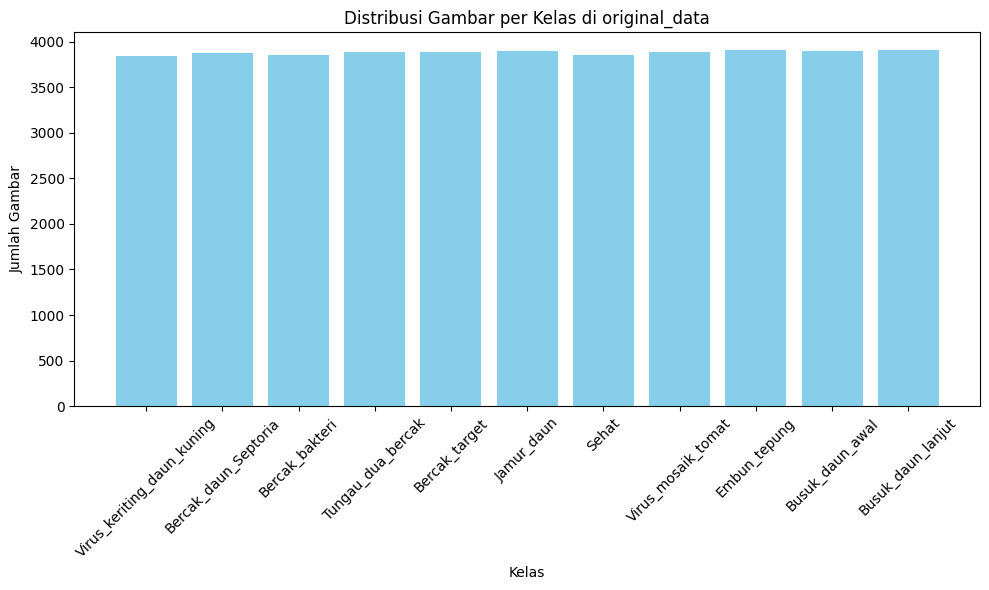

In [15]:
def plot_class_distribution(dataset_dir):
    """Menampilkan grafik distribusi jumlah gambar per kelas."""
    class_counts = {}

    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            num_images = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
            class_counts[class_name] = num_images

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title('Distribusi Gambar per Kelas di original_data')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Tampilkan grafik
plot_class_distribution('combine_data')

In [16]:
# Buat file zip dari folder combine_data
shutil.make_archive('combine_data', 'zip', 'combine_data')

'/content/combine_data.zip'